In [37]:
import jax
import jax.numpy as jnp
import jax.random as jr

from jax_moseq.utils.autoregression import random_rotation

from jax_moseq.models import twarhmm

from tqdm.auto import trange
import matplotlib.pyplot as plt

import seaborn as sns
from dynamax.utils.plotting import gradient_cmap

sns.set_style("white")
sns.set_context("talk")


color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


In [2]:
def print_dict(d, depth=0, ind='  '):
    if type(d) != dict:
        try:
            item = d.shape
        except AttributeError:
            item = d
        print(f'{ind * depth}{item}')
        return
    
    for k, v in d.items():
        print(f'{ind * depth}{k}')
        print_dict(v, depth + 1, ind)

In [92]:
# DATA GENERATION
# define model parameters
num_states = 5
num_sessions = 1
num_timesteps = 20000
emission_dim = 2
seed = jr.PRNGKey(23)
tau_values = jnp.array([0.75, 1, 1.33])

# weights + biases for starfish
keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

Ab = jnp.concatenate((weights - jnp.eye(2), biases[:,:,None]), axis=-1)
Q = covariances

# transitions
transition_probs = 0.1 ** jnp.arange(num_states)
transition_probs /= transition_probs.sum()
transition_matrix = jax.vmap(lambda k: jnp.roll(transition_probs, k))(jnp.arange(num_states))

pi_z = transition_matrix
pi_t = jnp.array([[0.90, 0.10, 0.00], 
                  [0.05, 0.90, 0.05],
                  [0.00, 0.10, 0.90]])


In [93]:
zs, ts, xs = jax.vmap(
    lambda seed: twarhmm.generate.generate_states(seed, pi_z, pi_t, Ab, Q, tau_values, num_timesteps)
    )(jr.split(seed, num_sessions))

data = {'x': jax.device_put(xs),
        'mask': jax.device_put(jnp.ones_like(zs))} #TODO: get rid of masks

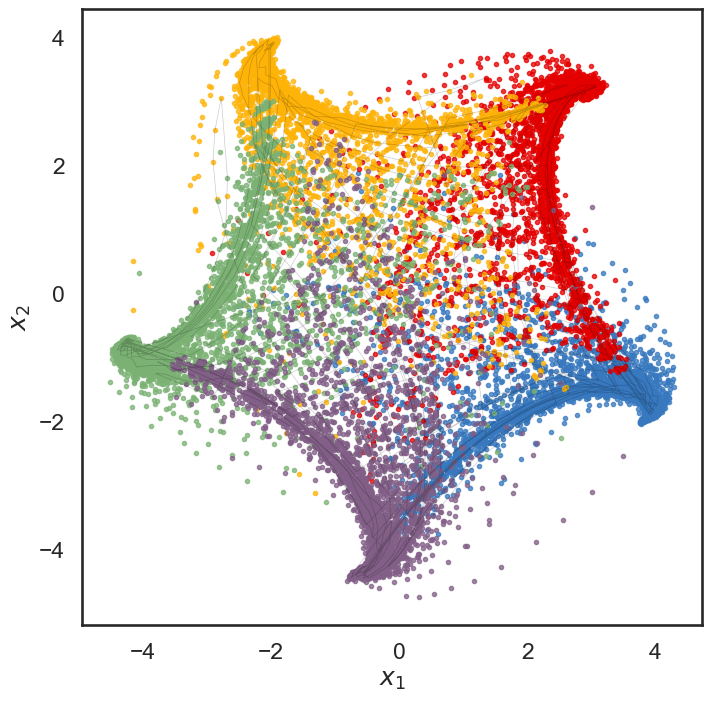

In [94]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*xs[0][zs[0]==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect(1.0)

In [95]:
latent_dim = obs_dim = data['x'].shape[-1]
num_states = 5          # max number of states
nlags = 1                 # number of lags for AR dynamics
#TODO: get rid of nlags (must be 1)

trans_hypparams = {
    'gamma': 1.0,
    'alpha': 1.0,
    'kappa': 1.0,
    'num_states':num_states,
    't_stick': 0.95
}

ar_hypparams = {
    'S_0_scale': .01,
    'K_0_scale': 10,
    'num_states':num_states,
    'nlags':  nlags,
    'latent_dim': latent_dim,
    'tau_values': tau_values
}

In [96]:
model = twarhmm.init_model(data,
                         ar_hypparams=ar_hypparams,
                         trans_hypparams=trans_hypparams,
                         verbose=True)

print_dict(model)

TWARHMM: Initializing hyperparameters
TWARHMM: Initializing parameters
TWARHMM: Initializing states
(1, 19999, 5, 3)
seed
  (2,)
hypparams
  trans_hypparams
    gamma
      1.0
    alpha
      1.0
    kappa
      1.0
    num_states
      5
    t_stick
      0.95
  ar_hypparams
    S_0_scale
      0.01
    K_0_scale
      10
    num_states
      5
    nlags
      1
    latent_dim
      2
    S_0
      (2, 2)
    K_0
      (3, 3)
    M_0
      (2, 3)
    nu_0
      4
params
  betas
    (5,)
  pi_z
    (5, 5)
  tau_values
    (3,)
  pi_t
    (3, 3)
  Ab
    (5, 2, 3)
  Q
    (5, 2, 2)
states
  z
    (1, 19999)
  t
    (1, 19999)


In [97]:
num_iters = 100    # number of training iterations

ll_keys = ['z', 'x', 't']
ll_history = {key: [] for key in ll_keys}

for i in trange(num_iters):
    # Perform Gibbs resampling
    ll = twarhmm.model_likelihood(data, **model)
    model = twarhmm.resample_model(data, **model, states_only=False)
    
    # Compute the likelihood of the data and
    # resampled states given the resampled params
    for key in ll_keys:
        ll_history[key].append(ll[key].item())

  1%|          | 1/100 [00:00<01:12,  1.36it/s]

(1, 19999, 5, 3)


100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


In [98]:
def plot_ll(key, ll_history):
    plt.title(f'Log Likelihood of {key}')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.plot(ll_history)
    plt.show()

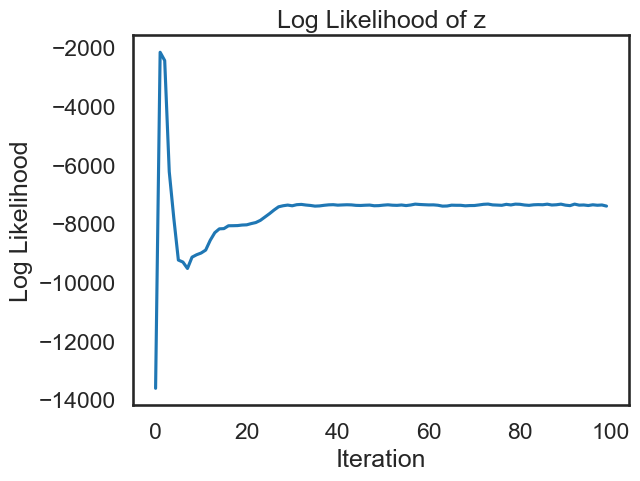

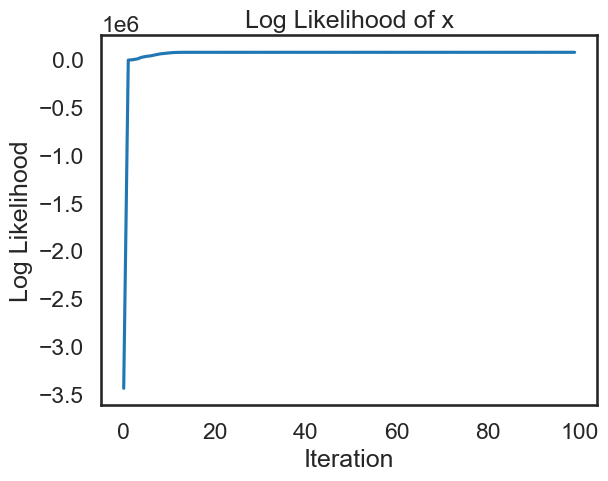

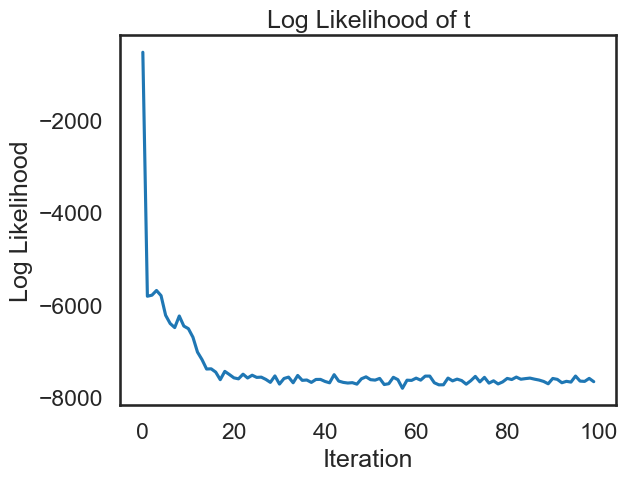

In [99]:
for k, v in ll_history.items():
    plot_ll(k, v)

In [100]:
model['params']['pi_t']

Array([[0.974359  , 0.02564103, 0.        ],
       [0.025     , 0.95000005, 0.025     ],
       [0.        , 0.02564103, 0.974359  ]], dtype=float32)

In [101]:
from jax_moseq.models.twarhmm.log_prob import discrete_stateseq_log_prob
discrete_stateseq_log_prob(zs[0], pi_z).sum()

Array(-7359.1016, dtype=float32)

In [102]:
discrete_stateseq_log_prob(ts[0], pi_t).sum()

Array(-7174.3535, dtype=float32)

Text(0, 0.5, '$x_2$')

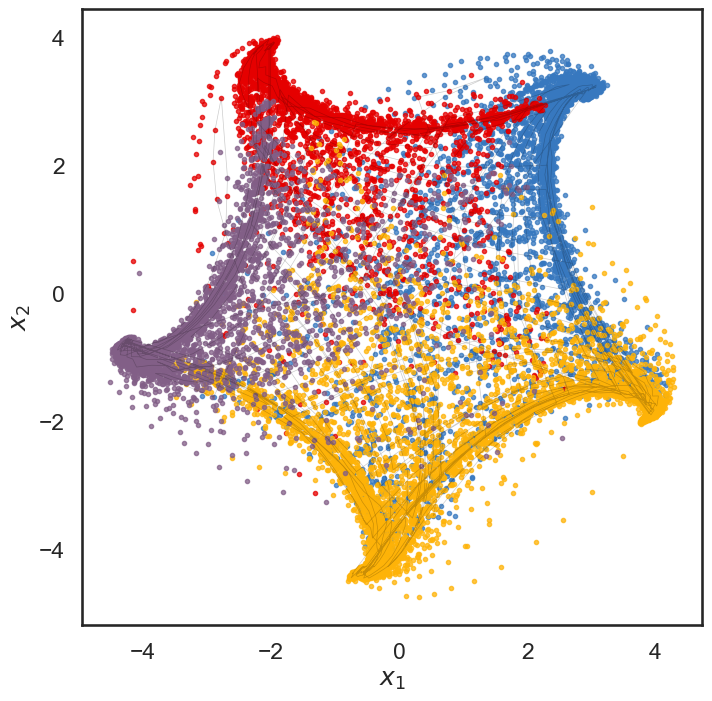

In [103]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*xs[0,1:][model['states']['z'][0]==k].T, 'o',
         color=colors[k], alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

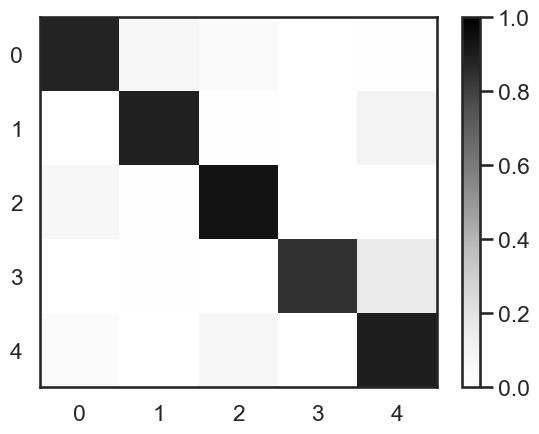

In [104]:
plt.imshow(model['params']['pi_z'], cmap="Greys", 
           interpolation="nearest", aspect="auto",
           vmin=0, vmax=1)
plt.colorbar()

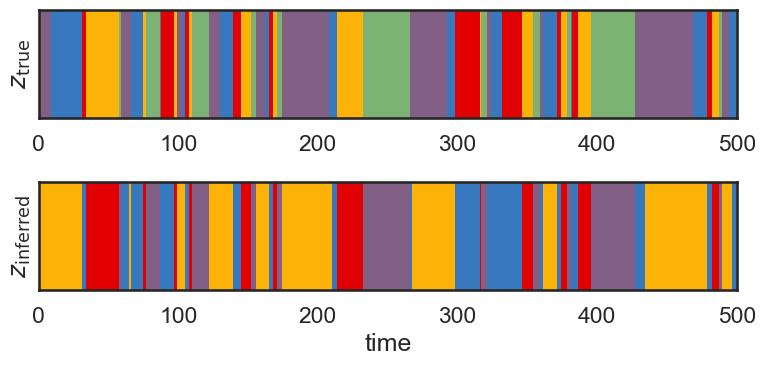

In [105]:
plot_slice = (0, 500)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(zs[None, 0, ar_hypparams['nlags']:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(model['states']['z'][None,0,:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

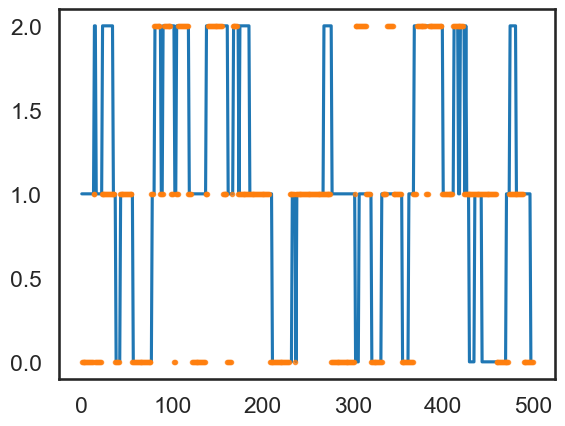

In [106]:
plt.plot(ts[0,:500], )
plt.plot(model['states']['t'][0,:500], 'o', alpha=0.75, markersize=3)